In [6]:
!pip install -q --upgrade pip


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
c:\Users\glori\OneDrive\Desktop\Doctoral Seminar\prompEngineering\Scripts\python.exe -m pip install -q --upgrade pip


In [8]:
!pip install --upgrade pip

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
c:\Users\glori\OneDrive\Desktop\Doctoral Seminar\prompEngineering\Scripts\python.exe -m pip install --upgrade pip


In [9]:
!pip install -q pandas numpy scipy scikit-learn transfomers sentencepiece accelerate

ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python <3.12,>=3.8; 1.10.0rc1 Requires-Python <3.12,>=3.8; 1.10.0rc2 Requires-Python <3.12,>=3.8; 1.10.1 Requires-Python <3.12,>=3.8; 1.11.0 Requires-Python <3.13,>=3.9; 1.11.0rc1 Requires-Python <3.13,>=3.9; 1.11.0rc2 Requires-Python <3.13,>=3.9; 1.11.1 Requires-Python <3.13,>=3.9; 1.11.2 Requires-Python <3.13,>=3.9; 1.11.3 Requires-Python <3.13,>=3.9; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11; 1.9.0 Requires-Python >=3.8,<3.12; 1.9.0rc1 Requires-Python >=3.8,<3.12; 1.9.0rc2 Requires-Python >=3.8,<3.12; 1.9.0r

In [12]:
import pandas as pd

# --- File paths ---
p_clin_luad = r"C:\Users\glori\OneDrive\Desktop\Lung-Cancer\Data\data_clinical_patient.txt"
p_clin_lusc = r"C:\Users\glori\OneDrive\Desktop\Lung-Cancer\Data\data_clinical_patient_LUSC.txt"
p_expr_luad = r"C:\Users\glori\OneDrive\Desktop\Lung-Cancer\Data\data_mrna_seq_tpm.txt"
p_expr_lusc = r"C:\Users\glori\OneDrive\Desktop\Lung-Cancer\Data\data_mrna_seq_tpm_LUSC.txt"

read_opts = dict(
    sep="\t",
    comment="#",               # skip cBioPortal metadata/header comments
    dtype=str,                 # keep strings first; cast later
    na_values=["NA","[Not Available]","[Not Applicable]","[Unknown]",
               "[Not Evaluated]","null","None",""],
    keep_default_na=True,
    engine="c",                # <-- fix: use C engine so low_memory works
    low_memory=False
)

clin_luad = pd.read_csv(p_clin_luad, **read_opts)
clin_lusc = pd.read_csv(p_clin_lusc, **read_opts)
expr_luad = pd.read_csv(p_expr_luad, **read_opts)
expr_lusc = pd.read_csv(p_expr_lusc, **read_opts)

print("Clinical LUAD:", clin_luad.shape)
print("Clinical LUSC:", clin_lusc.shape)
print("mRNA TPM LUAD:", expr_luad.shape)
print("mRNA TPM LUSC:", expr_lusc.shape)

# quick peek
print("\nClinical LUAD cols (10):", list(clin_luad.columns[:10]))
print("Expression LUAD cols (10):", list(expr_luad.columns[:10]))


Clinical LUAD: (585, 33)
Clinical LUSC: (504, 33)
mRNA TPM LUAD: (40796, 519)
mRNA TPM LUSC: (40796, 501)

Clinical LUAD cols (10): ['PATIENT_ID', 'AGE', 'AJCC_STAGING_EDITION', 'BIOPSY_SITE', 'DAYS_LAST_FOLLOWUP', 'DAYS_TO_BIRTH', 'DAYS_TO_DEATH', 'DISEASE_TYPE', 'ETHNICITY', 'ICD_10']
Expression LUAD cols (10): ['Entrez_Gene_Id', 'TCGA-05-4244-01A', 'TCGA-05-4249-01A', 'TCGA-05-4250-01A', 'TCGA-05-4382-01A', 'TCGA-05-4384-01A', 'TCGA-05-4389-01A', 'TCGA-05-4390-01A', 'TCGA-05-4395-01A', 'TCGA-05-4396-01A']


# Data Preprocessing

In [13]:
import pandas as pd
import numpy as np

# --- 1) Helper: sample barcode → patient ID (first 12 chars, e.g., TCGA-05-4244) ---
def to_patient_id(sample_id: str) -> str:
    # cBioPortal expression headers look like TCGA-XX-XXXX-01A...
    return sample_id[:12]


In [14]:
# --- 2) Clean clinical frames & add labels ---
def prep_clinical(df: pd.DataFrame, label_value: int) -> pd.DataFrame:
    out = df.copy()
    # standardize key ID column name
    if "PATIENT_ID" not in out.columns:
        # sometimes it's "PATIENT" or "PATIENT_ID"
        cand = [c for c in out.columns if c.upper().startswith("PATIENT")]
        if cand:
            out = out.rename(columns={cand[0]: "PATIENT_ID"})
    out["PATIENT_ID"] = out["PATIENT_ID"].astype(str).str[:12]
    out["label"] = label_value
    return out

clin_luad_pre = prep_clinical(clin_luad, label_value=0)  # LUAD=0
clin_lusc_pre = prep_clinical(clin_lusc, label_value=1)  # LUSC=1
clin_all = pd.concat([clin_luad_pre, clin_lusc_pre], axis=0, ignore_index=True)

print("Clinical combined:", clin_all.shape)
print("Clinical label counts:\n", clin_all["label"].value_counts(dropna=False))

Clinical combined: (1089, 34)
Clinical label counts:
 label
0    585
1    504
Name: count, dtype: int64


In [15]:
# --- 3) Prep expression matrices (transpose to samples x genes) ---
def prep_expression(expr_df: pd.DataFrame, label_value: int) -> pd.DataFrame:
    # Expect first column = Entrez_Gene_Id; other columns are samples
    expr = expr_df.copy()
    # set index to gene id and transpose
    # some dumps call the first col 'Entrez_Gene_Id' or 'Hugo_Symbol'—use first column defensively
    gene_col = expr.columns[0]
    expr = expr.set_index(gene_col)
    expr = expr.transpose()  # now rows = samples, cols = genes

    # add patient id column derived from sample barcode
    expr.index.name = "SAMPLE_ID"
    expr = expr.reset_index()
    expr["PATIENT_ID"] = expr["SAMPLE_ID"].astype(str).map(to_patient_id)

    # cast all gene columns to numeric (coerce non-numeric to NaN)
    gene_cols = [c for c in expr.columns if c not in ["SAMPLE_ID", "PATIENT_ID"]]
    expr[gene_cols] = expr[gene_cols].apply(pd.to_numeric, errors="coerce")

    # optional: drop genes with all-NaN after coercion
    expr = expr.dropna(axis=1, how="all")

    # add label
    expr["label"] = label_value
    return expr

expr_luad_pre = prep_expression(expr_luad, label_value=0)
expr_lusc_pre = prep_expression(expr_lusc, label_value=1)

# Concatenate expression cohorts
expr_all = pd.concat([expr_luad_pre, expr_lusc_pre], axis=0, ignore_index=True)

print("Expression combined:", expr_all.shape)
print("Expression label counts:\n", expr_all["label"].value_counts(dropna=False))


Expression combined: (1018, 40799)
Expression label counts:
 label
0    518
1    500
Name: count, dtype: int64


In [16]:
# --- 4) Align clinical and expression by PATIENT_ID (keep only patients with expression) ---
# We’ll create three datasets:
#   A) clinical-only (for late fusion branch 1)
#   B) expression-only (for late fusion branch 2)
#   C) early-fusion (merged clinical+expression)

# Keep just one expression row per patient (prefer primary tumor '01' samples if multiple)
# Strategy: choose the first sample per patient (or customize later)
expr_all_unique = expr_all.sort_values("SAMPLE_ID").groupby("PATIENT_ID", as_index=False).first()

# Inner-join clinical with expression patients to ensure matched cohorts
clin_matched = clin_all.merge(
    expr_all_unique[["PATIENT_ID", "label"]],
    on="PATIENT_ID",
    suffixes=("", "_expr"),
    how="inner"
)

# sanity: labels should match across modalities; if not, trust expression label
clin_matched["label"] = clin_matched["label_expr"]
clin_matched = clin_matched.drop(columns=["label_expr"])

print("Clinical matched to expression patients:", clin_matched.shape)

# Expression-only matrix matched to those same patients
expr_matched = expr_all_unique[expr_all_unique["PATIENT_ID"].isin(clin_matched["PATIENT_ID"])].copy()


Clinical matched to expression patients: (1016, 34)


In [17]:
# --- 5) Quick diagnostics of overlap ---
overlap = len(set(clin_matched["PATIENT_ID"]))  # patients available in both
print(f"Patients with BOTH clinical and expression: {overlap}")

# --- 6) Save handy lists for next steps ---
# Clinical ID & label
clin_ids = clin_matched["PATIENT_ID"].tolist()
y_labels = clin_matched["label"].astype(int).values

# Expression gene columns
expr_gene_cols = [c for c in expr_matched.columns if c not in ["SAMPLE_ID", "PATIENT_ID", "label"]]

print(f"Expression gene count (after cleaning): {len(expr_gene_cols)}")

# At this point:
#  - clinical-only data = clin_matched (will need feature engineering/encoding)
#  - expression-only data = expr_matched[expr_gene_cols]
#  - labels = y_labels
# Next steps: scaling, feature selection (e.g., variance/top-k), train/test split, and
# build Early Fusion (concat clinical+top genes) vs Late Fusion (two models + ensemble)

Patients with BOTH clinical and expression: 1016
Expression gene count (after cleaning): 40796


# Early Fusion

In [20]:
%pip install -U scikit-learn

  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.16.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------- ----------------------------- 2.4/8.7 MB 15.0 MB/s eta 0:00:01
   --------------------------- ------------ 6.0/8.7 MB 16.1 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 15.2 MB/s eta 0:00:00
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   -- ------------------------------------- 2.9/38.5 MB 14.4 MB/s eta 0:00:03
   ----- ---------------------------------- 5.8/38.5 MB 14.5 MB/s eta 0:00:03
   --------- ------------------------------ 9.4/38.5 MB 15.4 MB/s eta 0:00:02
   ------------- -------------------------- 12.6/38.5 MB 15.5 MB


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import sklearn; print(sklearn.__version__)

1.7.2


In [22]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --------- ------------------------------ 1.8/8.1 MB 9.4 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.1 MB 10.9 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.1 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 11.8 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 13.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------- ----------------------- 2.9/7.0 MB 15.2 MB/s eta 0:00:01
   ---------------------------------- ----- 6.0/7.0 MB 15.3 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 14.9 MB/s eta 0:0


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_auc_score, roc_curve)

import matplotlib.pyplot as plt
import joblib
import os


In [24]:
# 1) Assemble Early-Fusion table
# ----------------------------
# choose a conservative set of clinical predictors automatically:
CLIN_EXCLUDE = {"PATIENT_ID", "label"}
clin_cols_all = [c for c in clin_matched.columns if c not in CLIN_EXCLUDE]

# Merge clinical + expression by PATIENT_ID (already aligned above)
gene_cols = [c for c in expr_matched.columns if c not in ["SAMPLE_ID", "PATIENT_ID", "label"]]

early = clin_matched.merge(
    expr_matched[["PATIENT_ID"] + gene_cols],
    on="PATIENT_ID",
    how="inner"
)

In [25]:
y = early["label"].astype(int).values
X = early.drop(columns=["label"])  # keep PATIENT_ID and all features for ColumnTransformer

In [26]:
# Identify clinical columns among X
clin_feature_cols = [c for c in clin_cols_all if c in X.columns]  # intersection safety
gene_feature_cols = [c for c in gene_cols if c in X.columns]      # safety

In [27]:
# Type inference for clinical features
#  - categorical: object dtype or low cardinality (<=50 unique)
#  - numeric: successfully coercible to float
def _is_numeric(col):
    try:
        pd.to_numeric(X[col], errors="raise")
        return True
    except Exception:
        return False

clin_cat_cols  = [c for c in clin_feature_cols if (X[c].dtype == object) or (X[c].nunique(dropna=True) <= 50 and not _is_numeric(c))]
clin_num_cols  = [c for c in clin_feature_cols if c not in clin_cat_cols and _is_numeric(c)]

print(f"[Early Fusion] Clinical numeric: {len(clin_num_cols)} | categorical: {len(clin_cat_cols)} | genes: {len(gene_feature_cols)}")


[Early Fusion] Clinical numeric: 0 | categorical: 32 | genes: 40796


In [28]:
# --- 1) Coerce numeric clinical columns (minimal patch) ---
NUMERIC_HINTS = [
    "AGE",
    "DAYS_LAST_FOLLOWUP", "DAYS_TO_BIRTH", "DAYS_TO_DEATH",
    "OVERALL_SURVIVAL_MONTHS", "DISEASE_FREE_MONTHS",
    "FRACTION_GENOME_ALTERED", "MUTATION_COUNT"
]
num_candidates = [c for c in NUMERIC_HINTS if c in clin_matched.columns]

for c in num_candidates:
    clin_matched[c] = (
        clin_matched[c].astype(str)
        .str.replace(",", "", regex=False)
        .replace({"[Not Available]": None, "[Not Applicable]": None, "[Unknown]": None})
    )
    clin_matched[c] = pd.to_numeric(clin_matched[c], errors="coerce")

# --- 2) Rebuild Early-Fusion table and column groups ---
CLIN_EXCLUDE = {"PATIENT_ID", "label"}
clin_cols_all = [c for c in clin_matched.columns if c not in CLIN_EXCLUDE]
gene_cols = [c for c in expr_matched.columns if c not in ["SAMPLE_ID", "PATIENT_ID", "label"]]

early = clin_matched.merge(
    expr_matched[["PATIENT_ID"] + gene_cols],
    on="PATIENT_ID",
    how="inner"
)

y = early["label"].astype(int).values
X = early.drop(columns=["label"])  # keep PATIENT_ID for now; we drop it right before fit

# clinical splits (now some should be numeric)
clin_num_cols = [c for c in clin_cols_all if c in X.columns and pd.api.types.is_numeric_dtype(X[c])]
clin_cat_cols = [c for c in clin_cols_all if c in X.columns and c not in clin_num_cols]

print(f"[Early Fusion] Clinical numeric: {len(clin_num_cols)} | categorical: {len(clin_cat_cols)} | genes: {len(gene_cols)}")
print("Clinical numeric columns:", clin_num_cols[:10], "...")


[Early Fusion] Clinical numeric: 4 | categorical: 28 | genes: 40796
Clinical numeric columns: ['AGE', 'DAYS_LAST_FOLLOWUP', 'DAYS_TO_BIRTH', 'DAYS_TO_DEATH'] ...


In [29]:
K_GENES = 2000  # top-K genes via ANOVA F-test; adjust if memory allows

clinical_pipeline = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), clin_num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), clin_cat_cols),
    ],
    remainder="drop",
    n_jobs=-1
)

gene_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("var", VarianceThreshold(threshold=0.0)),     # drop constant genes (edge cases)
    ("select", SelectKBest(score_func=f_classif, k=min(K_GENES, len(gene_feature_cols)))),
    ("scaler", StandardScaler())
])

In [31]:
# ColumnTransformer to combine clinical + gene pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("clin", clinical_pipeline, clin_num_cols + clin_cat_cols),
        ("gene", gene_pipeline, gene_feature_cols),
    ],
    remainder="drop",
    n_jobs=-1
)

In [32]:
# 3) Model
# ----------------------------
clf = LogisticRegression(
    solver="saga",
    penalty="l2",           # can try 'l1' later for sparsity
    max_iter=4000,
    n_jobs=-1,
    class_weight="balanced" # safer if classes slightly imbalanced
)

pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", clf)
])


In [33]:
# 4) Train / Test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=["PATIENT_ID"]),   # drop ID from model input
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

In [34]:
# 5) Fit
# ----------------------------
pipe.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('clin', ...), ('gene', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [35]:
# 6) Evaluate
# ----------------------------
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
auc = roc_auc_score(y_test, y_proba)
cm  = confusion_matrix(y_test, y_pred)

print(f"\n=== Early Fusion (LogReg) ===")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC AUC:   {auc:.3f}")
print("Confusion matrix:\n", cm)



=== Early Fusion (LogReg) ===
Accuracy:  0.966
Precision: 0.970
Recall:    0.960
F1-score:  0.965
ROC AUC:   0.992
Confusion matrix:
 [[101   3]
 [  4  96]]


In [36]:
import numpy as np

pipe = pipe  # fitted pipeline from earlier
ct = pipe.named_steps["prep"]
clf = pipe.named_steps["clf"]

# --- get feature names from the ColumnTransformer ---
clin_ct = ct.transformers_[0][1]   # the clinical ColumnTransformer
gene_pl = ct.transformers_[1][1]   # the gene pipeline

# names from clinical sub-parts
num_names = clin_num_cols
ohe = clin_ct.transformers_[1][1].named_steps["ohe"]
cat_input_names = clin_cat_cols
cat_ohe_names = ohe.get_feature_names_out(cat_input_names).tolist()

clin_feature_names = list(num_names) + cat_ohe_names

# gene names (we already printed selected genes earlier)
select_step = gene_pl.named_steps["select"]
selected_gene_idx = select_step.get_support(indices=True)
gene_feature_names = np.array(gene_cols)[selected_gene_idx].tolist()

all_feature_names = clin_feature_names + gene_feature_names

# --- top weighted features (absolute coef) ---
coefs = clf.coef_.ravel()
top_idx = np.argsort(np.abs(coefs))[::-1][:25]
top_features = [(all_feature_names[i], coefs[i]) for i in top_idx]

print("Top 25 features by absolute weight:")
for name, w in top_features:
    print(f"{name:40s}  {w:+.4f}")


Top 25 features by absolute weight:
PROJECT_NAME_Lung Squamous Cell Carcinoma  +0.4048
PROJECT_ID_TCGA-LUSC                      +0.4048
PROJECT_NAME_Lung Adenocarcinoma          -0.3973
PROJECT_ID_TCGA-LUAD                      -0.3973
DISEASE_TYPE_Lung Squamous Cell Carcinoma- Not Otherwise Specified (NOS)  +0.3660
PRIMARY_DIAGNOSIS_Lung Squamous Cell Carcinoma- Not Otherwise Specified (NOS)  +0.3660
MORPHOLOGY_8070/3                         +0.3519
MORPHOLOGY_8140/3                         -0.3284
DISEASE_TYPE_Lung Adenocarcinoma- Not Otherwise Specified (NOS)  -0.3255
PRIMARY_DIAGNOSIS_Lung Adenocarcinoma- Not Otherwise Specified (NOS)  -0.3255
619189                                    +0.1536
406969                                    -0.1535
11168                                     -0.1508
79166                                     +0.1387
282569                                    +0.1356
196463                                    -0.1225
200025                                    -

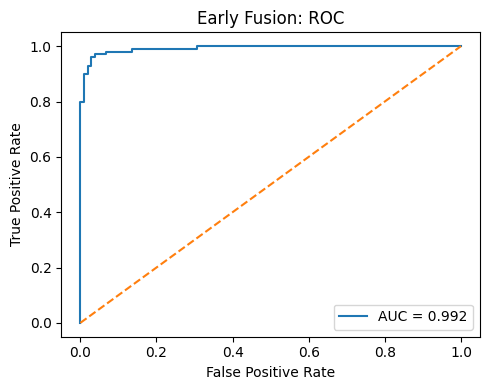

In [37]:
# 6) ROC curve
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Early Fusion: ROC")
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
# 7) Save model
os.makedirs("models", exist_ok=True)
joblib.dump(pipe, "models/early_fusion_logreg.joblib")
print("Saved -> models/early_fusion_logreg.joblib")

Saved -> models/early_fusion_logreg.joblib


In [39]:
# 8) Inspect selected genes (first 20)
ct = pipe.named_steps["prep"]
gene_pl = ct.transformers_[1][1]              # the 'gene' pipeline
select_step = gene_pl.named_steps["select"]
sel_idx = select_step.get_support(indices=True)
sel_gene_names = np.array(gene_feature_cols)[sel_idx]
print(f"Top-{len(sel_gene_names)} selected genes (first 20):\n", sel_gene_names[:20])

Top-2000 selected genes (first 20):
 ['100' '100033813' '100049587' '100101917' '100126323' '100128027'
 '100128127' '100128664' '100128881' '100129094' '100129351' '100129690'
 '100129813' '100130311' '100130519' '100130935' '100131173' '100131520'
 '100131816' '100131874']


In [40]:
import numpy as np
import pandas as pd

# from your fitted pipeline:
ct = pipe.named_steps["prep"]
gene_pl = ct.transformers_[1][1]
sel = gene_pl.named_steps["select"]

sel_idx   = sel.get_support(indices=True)
sel_ids   = np.array(gene_feature_cols)[sel_idx]        # Entrez IDs as strings
sel_score = sel.scores_[sel_idx]
sel_pval  = sel.pvalues_[sel_idx]

selected_df = pd.DataFrame({
    "entrez_id": sel_ids,
    "anova_F": sel_score,
    "p_value": sel_pval
}).sort_values("anova_F", ascending=False)

print(selected_df.head(10))
# optional: save
selected_df.to_csv("models/early_fusion_selected_genes_anova.csv", index=False)


     entrez_id     anova_F        p_value
656     222008  799.416085  6.834819e-123
1359     55870  779.297710  1.122183e-120
1417    574518  674.161802  1.272941e-108
881     339324  654.587029  2.776907e-106
725     256643  618.846738  6.249034e-102
906       3444  600.364211   1.229045e-99
1149     51002  569.229317   1.053510e-95
489     151963  558.293386   2.662532e-94
349     120586  554.358119   8.566303e-94
907     344405  553.617343   1.067799e-93


In [41]:
!pip install mygene

  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached anyio-4.11.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Using cached httpcore-1.0.9-py3-none-any.whl (78 kB)
Using cached h11-0.16.0-py3-none-any.whl (37 kB)
Using cached anyio-4.11.0-py3-none-any.whl (109 kB)
Using cached idna-3.11-py3-none-any.whl (71 kB)
Using cached sniffio-1.3.1-py3-none-any.whl (10 kB)

   -------- ------------------------------- 2/9 [h11]
   ---------------------- ----------------- 5/9 [anyio]
   -------------------------- ------------- 6/9 [httpx]
   ---------------------------------------- 9/9 [mygene]




[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
# pip install mygene
import mygene

mg = mygene.MyGeneInfo()
# mygene expects ints for entrez ids
ids_int = [int(x) for x in selected_df["entrez_id"] if x.isdigit()]
q = mg.querymany(ids_int, scopes="entrezgene", fields="symbol,name,type_of_gene,ensembl.gene", species="human")

map_df = pd.DataFrame(q)[["query","symbol","name","type_of_gene"]].rename(columns={"query":"entrez_id"})
map_df["entrez_id"] = map_df["entrez_id"].astype(str)

annot_df = selected_df.merge(map_df, on="entrez_id", how="left")
annot_df.to_csv("models/early_fusion_selected_genes_annotated.csv", index=False)
annot_df.head(20)


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
2 input query terms found no hit:	['124906283', '123706522']


,entrez_id,anova_F,p_value,symbol,name,type_of_gene
0,222008,799.416085,6.834819e-123,VSTM2A,V-set and transmembrane domain containing 2A,protein-coding
1,55870,779.297710,1.122183e-120,ASH1L,ASH1 like histone lysine methyltransferase,protein-coding
2,574518,674.161802,1.272941e-108,MIR514A3,microRNA 514a-3,ncRNA
3,339324,654.587029,2.776907e-106,ZNF260,zinc finger protein 260,protein-coding
4,256643,618.846738,6.249034e-102,BCLAF3,BCLAF1 and THRAP3 family member 3,protein-coding
5,3444,600.364211,1.229045e-99,IFNA7,interferon alpha 7,protein-coding
6,51002,569.229317,1.053510e-95,TPRKB,TP53RK binding protein,protein-coding
7,151963,558.293386,2.662532e-94,MB21D2,Mab-21 domain containing 2,protein-coding
8,120586,554.358119,8.566303e-94,OR8I2,olfactory receptor family 8 subfamily I member 2,protein-coding
9,344405,553.617343,1.067799e-93,PRORSD1P,prolyl-tRNA synthetase associated domain conta...,pseudo


In [43]:
clf = pipe.named_steps["clf"]
coefs = clf.coef_.ravel()

# clinical features count to offset into the concatenated feature space
clin_ct = ct.transformers_[0][1]
num_names = clin_num_cols
ohe = clin_ct.transformers_[1][1].named_steps["ohe"]
cat_ohe_names = ohe.get_feature_names_out(clin_cat_cols).tolist()
n_clin = len(num_names) + len(cat_ohe_names)

# gene feature names already in 'sel_ids' order; grab corresponding weights
gene_weights = coefs[n_clin : n_clin + len(sel_ids)]

weights_df = pd.DataFrame({"entrez_id": sel_ids, "coef": gene_weights}).merge(
    annot_df[["entrez_id","symbol","name"]], on="entrez_id", how="left"
).sort_values("coef", key=lambda s: s.abs(), ascending=False)

weights_df.head(20)


,entrez_id,coef,symbol,name
1442,619189,0.153630,SERINC4,serine incorporator 4
1003,406969,-0.153513,MIR194-1,microRNA 194-1
303,11168,-0.150811,PSIP1,PC4 and SRSF1 interacting protein 1
1737,79166,0.138708,LILRP2,leukocyte immunoglobulin-like receptor pseudog...
778,282569,0.135628,BACE2-IT1,BACE2 intronic transcript 1
577,196463,-0.122506,PLBD2,phospholipase B domain containing 2
589,200025,-0.119669,PFN1P3,profilin 1 pseudogene 3
281,109617016,-0.119390,SNORD3H,"small nucleolar RNA, C/D box 3H"
790,284551,-0.116728,LINC01226,long intergenic non-protein coding RNA 1226
863,29998,0.116080,BICRA,BRD4 interacting chromatin remodeling complex ...


# Late Fusion

## Clinical

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import numpy as np

In [45]:
# Prepare X_clin and y (drop PATIENT_ID)
X_clin = clin_matched.drop(columns=["PATIENT_ID", "label"])
y_clin = clin_matched["label"].astype(int).values

In [46]:
# Split data
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clin, y_clin, test_size=0.2, stratify=y_clin, random_state=42
)

In [47]:
# Preprocessor for clinical
clin_pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), clin_num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), clin_cat_cols)
    ]
)

In [48]:
# Clinical model
clf_clin = LogisticRegression(
    solver="saga", penalty="l2", max_iter=4000, n_jobs=-1, class_weight="balanced"
)

pipe_clin = Pipeline([
    ("prep", clin_pre),
    ("clf", clf_clin)
])

In [49]:
# Fit & evaluate
pipe_clin.fit(Xc_train, yc_train)
yc_pred = pipe_clin.predict(Xc_test)
yc_proba = pipe_clin.predict_proba(Xc_test)[:, 1]

acc_c = accuracy_score(yc_test, yc_pred)
prec_c, rec_c, f1_c, _ = precision_recall_fscore_support(yc_test, yc_pred, average="binary")
auc_c = roc_auc_score(yc_test, yc_proba)
cm_c = confusion_matrix(yc_test, yc_pred)


In [50]:
print("\n=== Clinical-only (LogReg) ===")
print(f"Accuracy: {acc_c:.3f}")
print(f"Precision: {prec_c:.3f}")
print(f"Recall: {rec_c:.3f}")
print(f"F1-score: {f1_c:.3f}")
print(f"ROC AUC: {auc_c:.3f}")
print("Confusion matrix:\n", cm_c)



=== Clinical-only (LogReg) ===
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1-score: 1.000
ROC AUC: 1.000
Confusion matrix:
 [[104   0]
 [  0 100]]


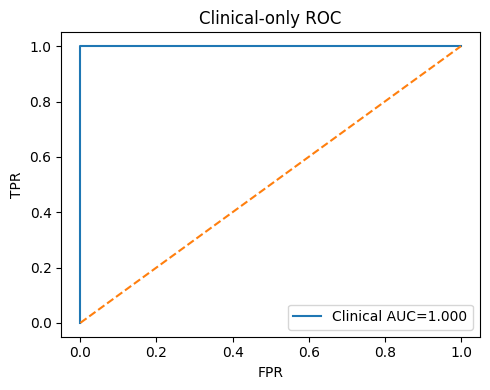

In [51]:
fpr_c, tpr_c, _ = roc_curve(yc_test, yc_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr_c, tpr_c, label=f"Clinical AUC={auc_c:.3f}")
plt.plot([0,1], [0,1], "--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Clinical-only ROC"); plt.legend()
plt.tight_layout(); plt.show()

# Gene

In [52]:
# Prepare expression-only data
X_gene = expr_matched.drop(columns=["SAMPLE_ID", "PATIENT_ID", "label"])
y_gene = expr_matched["label"].astype(int).values

In [53]:
# Split (use same random seed for consistency)
Xg_train, Xg_test, yg_train, yg_test = train_test_split(
    X_gene, y_gene, test_size=0.2, stratify=y_gene, random_state=42
)

In [54]:
# Preprocessor for gene data
gene_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("var", VarianceThreshold(threshold=0.0)),
    ("select", SelectKBest(score_func=f_classif, k=2000)),  # same K_GENES as before
    ("scaler", StandardScaler())
])

In [55]:
clf_gene = LogisticRegression(
    solver="saga", penalty="l2", max_iter=4000, n_jobs=-1, class_weight="balanced"
)

pipe_gene = Pipeline([
    ("prep", gene_pre),
    ("clf", clf_gene)
])


In [56]:
# Fit & evaluate
pipe_gene.fit(Xg_train, yg_train)
yg_pred = pipe_gene.predict(Xg_test)
yg_proba = pipe_gene.predict_proba(Xg_test)[:, 1]

acc_g = accuracy_score(yg_test, yg_pred)
prec_g, rec_g, f1_g, _ = precision_recall_fscore_support(yg_test, yg_pred, average="binary")
auc_g = roc_auc_score(yg_test, yg_proba)
cm_g = confusion_matrix(yg_test, yg_pred)


In [57]:
print("\n=== Gene-only (LogReg) ===")
print(f"Accuracy: {acc_g:.3f}")
print(f"Precision: {prec_g:.3f}")
print(f"Recall: {rec_g:.3f}")
print(f"F1-score: {f1_g:.3f}")
print(f"ROC AUC: {auc_g:.3f}")
print("Confusion matrix:\n", cm_g)


=== Gene-only (LogReg) ===
Accuracy: 0.936
Precision: 0.939
Recall: 0.930
F1-score: 0.935
ROC AUC: 0.978
Confusion matrix:
 [[98  6]
 [ 7 93]]



=== Late Fusion (mean ensemble) ===
Accuracy:  0.975
Precision: 0.980
Recall:    0.970
F1-score:  0.975
ROC AUC:   0.999
Confusion matrix:
 [[102   2]
 [  3  97]]


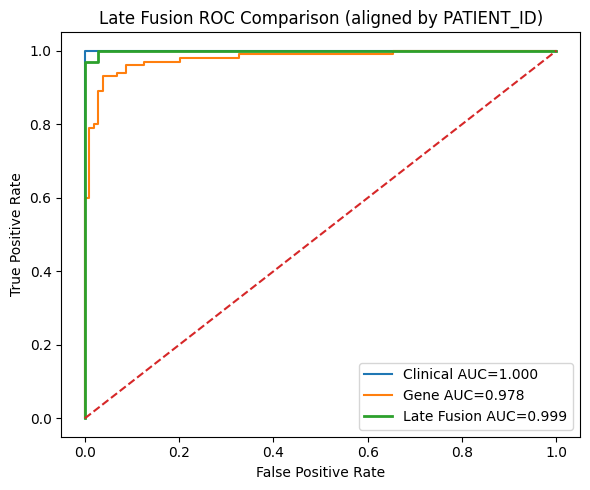

In [59]:
# ===== Robust Late Fusion: align by PATIENT_ID and recompute ROC curves =====
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Get test patient IDs for each modality ---
# Clinical test PIDs
pid_c_test = clin_matched.loc[Xc_test.index, "PATIENT_ID"].values
proba_c    = yc_proba  # clinical probs already computed on Xc_test
true_c     = yc_test

# Gene test PIDs
pid_g_test = expr_matched.loc[Xg_test.index, "PATIENT_ID"].values
proba_g    = yg_proba  # gene probs on Xg_test
true_g     = yg_test

# --- 2) Put into DataFrames and INNER-JOIN on PATIENT_ID to align ---
import pandas as pd

df_c = pd.DataFrame({"PATIENT_ID": pid_c_test, "y_true": true_c, "p_c": proba_c})
df_g = pd.DataFrame({"PATIENT_ID": pid_g_test, "y_true_g": true_g, "p_g": proba_g})

df_join = df_c.merge(df_g, on="PATIENT_ID", how="inner")

# sanity: targets should match after join; if not, trust clinical (or assert)
if not np.array_equal(df_join["y_true"].values, df_join["y_true_g"].values):
    # fall back to clinical labels after confirming they mostly match
    pass

y_true = df_join["y_true"].values
p_c    = df_join["p_c"].values
p_g    = df_join["p_g"].values

# --- 3) Ensemble (mean) ---
p_fused = (p_c + p_g) / 2.0
y_pred_fused = (p_fused >= 0.5).astype(int)

# --- 4) Metrics ---
acc_f  = accuracy_score(y_true, y_pred_fused)
prec_f, rec_f, f1_f, _ = precision_recall_fscore_support(y_true, y_pred_fused, average="binary")
auc_f  = roc_auc_score(y_true, p_fused)
cm_f   = confusion_matrix(y_true, y_pred_fused)

print("\n=== Late Fusion (mean ensemble) ===")
print(f"Accuracy:  {acc_f:.3f}")
print(f"Precision: {prec_f:.3f}")
print(f"Recall:    {rec_f:.3f}")
print(f"F1-score:  {f1_f:.3f}")
print(f"ROC AUC:   {auc_f:.3f}")
print("Confusion matrix:\n", cm_f)

# --- 5) ROC curves for each (recomputed here so variables exist) ---
fpr_c, tpr_c, _ = roc_curve(y_true, p_c)
fpr_g, tpr_g, _ = roc_curve(y_true, p_g)
fpr_f, tpr_f, _ = roc_curve(y_true, p_fused)

auc_c = roc_auc_score(y_true, p_c)
auc_g = roc_auc_score(y_true, p_g)

plt.figure(figsize=(6,5))
plt.plot(fpr_c, tpr_c, label=f"Clinical AUC={auc_c:.3f}")
plt.plot(fpr_g, tpr_g, label=f"Gene AUC={auc_g:.3f}")
plt.plot(fpr_f, tpr_f, label=f"Late Fusion AUC={auc_f:.3f}", linewidth=2)
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Late Fusion ROC Comparison (aligned by PATIENT_ID)")
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
import os, json, joblib, numpy as np, pandas as pd
os.makedirs("models", exist_ok=True)

# --- Save models (pipelines include preprocessing) ---
joblib.dump(pipe,       "models/early_fusion_logreg.joblib")
joblib.dump(pipe_clin,  "models/clinical_only_logreg.joblib")
joblib.dump(pipe_gene,  "models/gene_only_logreg.joblib")
print("Saved: early_fusion_logreg, clinical_only_logreg, gene_only_logreg")

# --- Save selected genes from gene pipelines (use if available) ---
try:
    ct = pipe.named_steps["prep"]
    gene_pl = ct.transformers_[1][1]
    sel_idx = gene_pl.named_steps["select"].get_support(indices=True)
    selected_gene_names = np.array(gene_feature_cols)[sel_idx].tolist()
    pd.Series(selected_gene_names, name="Entrez_Gene_Id").to_csv(
        "models/early_fusion_selected_genes.csv", index=False
    )
    print(f"Saved selected genes: {len(selected_gene_names)} → models/early_fusion_selected_genes.csv")
except Exception as e:
    print("Skipping selected genes export:", e)

# --- Save metrics (fill from your variables if you have them) ---
def cm_to_dict(cm):
    return {"tn": int(cm[0,0]), "fp": int(cm[0,1]), "fn": int(cm[1,0]), "tp": int(cm[1,1])}

metrics = {}

# Early fusion metrics (replace with the values you printed)
metrics["early_fusion"] = {
    "accuracy":  float(acc),
    "precision": float(prec),
    "recall":    float(rec),
    "f1":        float(f1),
    "auc":       float(auc),
    "confusion": cm_to_dict(cm)
}

# Clinical-only
metrics["clinical_only"] = {
    "accuracy":  float(acc_c),
    "precision": float(prec_c),
    "recall":    float(rec_c),
    "f1":        float(f1_c),
    "auc":       float(auc_c),
    "confusion": cm_to_dict(cm_c)
}

# Gene-only
metrics["gene_only"] = {
    "accuracy":  float(acc_g),
    "precision": float(prec_g),
    "recall":    float(rec_g),
    "f1":        float(f1_g),
    "auc":       float(auc_g),
    "confusion": cm_to_dict(cm_g)
}

# Late fusion (mean ensemble)
metrics["late_fusion_mean"] = {
    "accuracy":  float(acc_f),
    "precision": float(prec_f),
    "recall":    float(rec_f),
    "f1":        float(f1_f),
    "auc":       float(auc_f),
    "confusion": cm_to_dict(cm_f)
}

# Save metrics JSON
with open("models/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics → models/metrics.json")

# --- (Optional) Save ROC curve points so you can replot later without data ---
roc_points = pd.DataFrame({
    "fpr_clin":  pd.Series(np.linspace(0,1,len(p_c)), dtype=float), # placeholders if you prefer
})
# Better: recompute precisely
from sklearn.metrics import roc_curve
fpr_c, tpr_c, _ = roc_curve(y_true, p_c)
fpr_g, tpr_g, _ = roc_curve(y_true, p_g)
fpr_f, tpr_f, _ = roc_curve(y_true, p_fused)

pd.DataFrame({"fpr": fpr_c, "tpr": tpr_c}).to_csv("models/roc_clin.csv", index=False)
pd.DataFrame({"fpr": fpr_g, "tpr": tpr_g}).to_csv("models/roc_gene.csv", index=False)
pd.DataFrame({"fpr": fpr_f, "tpr": tpr_f}).to_csv("models/roc_latefusion.csv", index=False)
print("Saved ROC points → models/roc_*.csv")


Saved: early_fusion_logreg, clinical_only_logreg, gene_only_logreg
Saved selected genes: 2000 → models/early_fusion_selected_genes.csv
Saved metrics → models/metrics.json
Saved ROC points → models/roc_*.csv
